# Taxi Fare Prediction with XGBoost

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Import Data

In [2]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.dropna(inplace=True)

pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', axis=1, inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude) 
df.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1,
       inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [3]:
df = df[(df.fare_amount > 0) & (df.distance > 0)]

## Dataset Splitting 

In [4]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14705, 6), (3677, 6), (14705,), (3677,))

## Modeling

In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real

In [6]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [7]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['passenger_count','year','distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month','day','hour']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=10, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.1min finished


{'algo__colsample_bytree': 0.5261245937025092, 'algo__gamma': 1, 'algo__learning_rate': 0.08498604636076731, 'algo__max_depth': 5, 'algo__n_estimators': 122, 'algo__reg_alpha': 0.0015568103018717575, 'algo__reg_lambda': 6.2601238645330595, 'algo__subsample': 0.7433401936490238}
0.8458543980193373 0.786788862522452 0.7894294452508215


Wow, terjadi kenaikan skor (R-square) yang signifikan pada train, val dan terutama test sebesar >4 % dibandingkan sebelumnya menggunakan linear regression.

## Features Important 

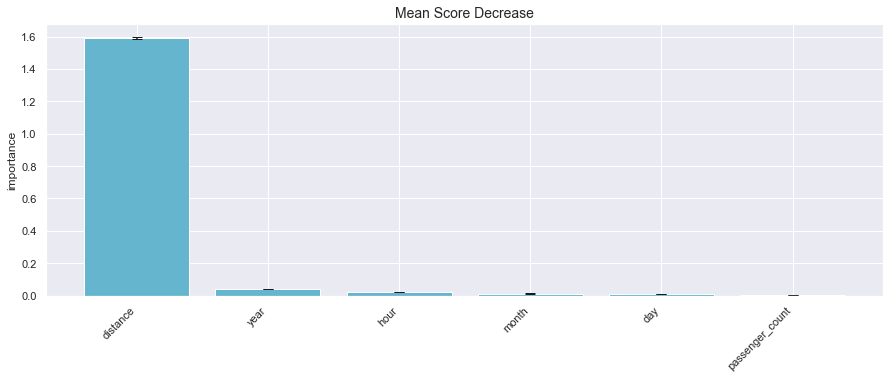

In [8]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

Distance masih fitur paling penting dalam memprediksi harga/biaya taksi.

## Polynomial Features 

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['passenger_count','year','distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month','day','hour']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=10, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.1min finished


{'algo__colsample_bytree': 0.8943727088704059, 'algo__gamma': 7, 'algo__learning_rate': 0.04764963542138517, 'algo__max_depth': 3, 'algo__n_estimators': 118, 'algo__reg_alpha': 0.8013508750140631, 'algo__reg_lambda': 3.8765111709116367, 'algo__subsample': 0.7435432121325587, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.8113591071339525 0.7872050570511688 0.7905555619934759


Setelah dilakukan polynomial features terjadi kenaikan pada val dan test.

## Evaluasi 

In [10]:
from jcopml.plot import plot_residual

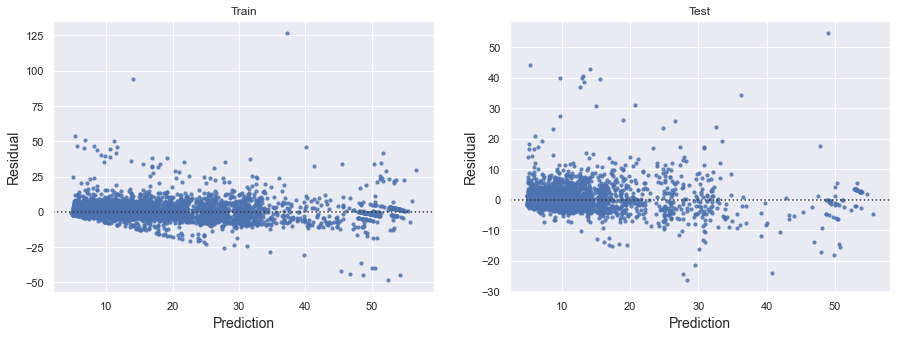

In [11]:
plot_residual(X_train, y_train, X_test, y_test, model)

Dari residual plot di atas saya melihat masih ada pola kekurangan informasi walaupun skor terjadi peningkatan yang signifikan. Artinya memang fitur yang ada belum cukup untuk memprediksi harga/biaya taksi sehingga seharusnya ada fitur tambahan yang dapat digunakan untuk membantu model melakukan prediksi lebih baik lagi.

## Save Model

In [12]:
save_model(model.best_estimator_, "Taxi_Fare.pkl")

Model is pickled as model/Taxi_Fare.pkl
